# BreakHis Image Classification with 🤗 Vision Transformers and `TensorFlow`

### Quick intro: Vision Transformer (ViT) by Google Brain
The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

* [Original paper](https://arxiv.org/abs/2010.11929)
* [Official repo (in JAX)](https://github.com/google-research/vision_transformer)
* [🤗 Vision Transformer](https://huggingface.co/docs/transformers/model_doc/vit)
* [Pre-trained model](https://huggingface.co/google/vit-base-patch16-224-in21k)

## Installation

In [1]:
# !pip install transformers datasets "tensorflow==2.6.0" --upgrade

## Setup & Configuration

In this step, we will define global configurations and parameters, which are used across the whole end-to-end fine-tuning process, e.g. `feature extractor` and `model` we will use. 

In this example we are going to fine-tune the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.
There are also [large](https://huggingface.co/google/vit-large-patch16-224-in21k) and [huge](https://huggingface.co/google/vit-huge-patch14-224-in21k) flavors of original ViT.

In [2]:
model_id = "google/vit-base-patch16-224-in21k"

## Dataset & Pre-processing

- **Data Source:** https://www.kaggle.com/code/nasrulhakim86/breast-cancer-histopathology-images-classification/data
- The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients.
- The images are collected using different magnifying factors (40X, 100X, 200X, and 400X). 
- To date, it contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format).
- This database has been built in collaboration with the P&D Laboratory – Pathological Anatomy and Cytopathology, Parana, Brazil (http://www.prevencaoediagnose.com.br). 
- Each image filename stores information about the image itself: method of procedure biopsy, tumor class, tumor type, patient identification, and magnification factor. 
- For example, SOBBTA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB.

The `BreakHis` is not yet available as a dataset in the `datasets` library. To be able to create a `Dataset` instance we need to write a small little helper function, which will load our `Dataset` from the filesystem and create the instance to use later for training.

This notebook assumes that the dataset is available in directory tree next to this file and its directory name is `breakhis_400x`

In [27]:
from pathlib import Path
cwd = Path().absolute()
input_path = cwd / 'breakhis_400x'
output_path = cwd / 'output'

In [5]:
from datasets import load_dataset

ds = load_dataset('imagefolder', data_dir=input_path)
ds

Resolving data files:   0%|          | 0/1820 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/miki/.cache/huggingface/datasets/imagefolder/default-1b334e2228fbca9c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1820
    })
})

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x7F87C835C970>, 'label': 0}


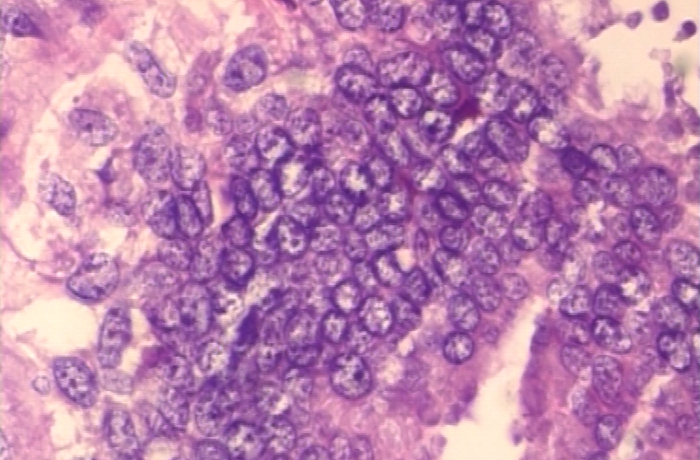

In [6]:
ex = ds['train'][400]
print(ex)

image = ex['image']
image

In [7]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['benign', 'malignant'], id=None)

In [8]:
labels.int2str(ex['label'])

'benign'

In [9]:
labels.names

['benign', 'malignant']

### Pre-processing

To train our model we need to convert our "Images" to `pixel_values`. This is done by a [🤗 Transformers Image Processor](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTImageProcessor) which allows us to `augment` and convert the images into a 3D Array to be fed into our model.

In [13]:
from transformers import ViTImageProcessor

image_processor = ViTImageProcessor.from_pretrained(model_id)

**TODO**: Use `ViTImageProcessor` instead of `ViTFeatureExtractor`

In [14]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
image_processor(image, return_tensors='tf')

2023-03-26 10:42:10.589801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 10:42:10.622772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 10:42:10.622960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 10:42:10.624302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

{'pixel_values': <tf.Tensor: shape=(1, 3, 224, 224), dtype=float32, numpy=
array([[[[ 0.69411767,  0.7019608 ,  0.8039216 , ...,  0.9764706 ,
           0.9843137 ,  0.92156863],
         [ 0.654902  ,  0.67058825,  0.7176471 , ...,  0.96862745,
           0.9764706 ,  0.9137255 ],
         [ 0.5921569 ,  0.67058825,  0.67058825, ...,  0.9607843 ,
           0.9607843 ,  0.9137255 ],
         ...,
         [ 0.69411767,  0.92156863,  0.827451  , ...,  0.54509807,
           0.5137255 ,  0.35686278],
         [ 0.85882354,  0.8509804 ,  0.7176471 , ...,  0.49803925,
           0.47450984,  0.32549024],
         [ 0.92156863,  0.7019608 ,  0.6       , ...,  0.45882356,
           0.47450984,  0.35686278]],

        [[ 0.27843142,  0.2313726 ,  0.30980396, ...,  0.7176471 ,
           0.7176471 ,  0.69411767],
         [ 0.24705887,  0.20784318,  0.24705887, ...,  0.7176471 ,
           0.70980394,  0.69411767],
         [ 0.19215691,  0.22352946,  0.22352946, ...,  0.7176471 ,
          

In [16]:
def process_example(example):
    inputs = image_processor(example['image'], return_tensors='tf')
    inputs['labels'] = example['label']
    return inputs

In [17]:
process_example(ds['train'][0])

{'pixel_values': <tf.Tensor: shape=(1, 3, 224, 224), dtype=float32, numpy=
array([[[[ 0.54509807,  0.56078434,  0.5529412 , ...,  0.54509807,
           0.5529412 ,  0.54509807],
         [ 0.5686275 ,  0.5764706 ,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.5372549 ],
         [ 0.5764706 ,  0.58431375,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.54509807],
         ...,
         [ 0.20000005,  0.23921573,  0.24705887, ...,  0.5686275 ,
           0.5764706 ,  0.5686275 ],
         [ 0.20784318,  0.24705887,  0.254902  , ...,  0.5764706 ,
           0.58431375,  0.58431375],
         [ 0.23921573,  0.27843142,  0.2941177 , ...,  0.5764706 ,
           0.5764706 ,  0.5764706 ]],

        [[ 0.33333337,  0.30196083,  0.33333337, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.3411765 ,  0.32549024,  0.34901965, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.34901965,  0.32549024,  0.33333337, ...,  0.69411767,
          

In [18]:


def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = image_processor([x for x in example_batch['image']], return_tensors='tf')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

# TODO Add data augmentation if needed
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers
# data_augmentation = Sequential(
#     [
#         layers.Resizing(image_processor.size, image_processor.size),
#         layers.Rescaling(1./255),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="data_augmentation",
# )

# def augmentation(examples):
#     # print(examples["img"])
#     examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
#     return examples

prepared_ds = ds.with_transform(transform)

In [19]:
prepared_ds['train'][0:2]

{'pixel_values': <tf.Tensor: shape=(2, 3, 224, 224), dtype=float32, numpy=
array([[[[ 0.54509807,  0.56078434,  0.5529412 , ...,  0.54509807,
           0.5529412 ,  0.54509807],
         [ 0.5686275 ,  0.5764706 ,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.5372549 ],
         [ 0.5764706 ,  0.58431375,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.54509807],
         ...,
         [ 0.20000005,  0.23921573,  0.24705887, ...,  0.5686275 ,
           0.5764706 ,  0.5686275 ],
         [ 0.20784318,  0.24705887,  0.254902  , ...,  0.5764706 ,
           0.58431375,  0.58431375],
         [ 0.23921573,  0.27843142,  0.2941177 , ...,  0.5764706 ,
           0.5764706 ,  0.5764706 ]],

        [[ 0.33333337,  0.30196083,  0.33333337, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.3411765 ,  0.32549024,  0.34901965, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.34901965,  0.32549024,  0.33333337, ...,  0.69411767,
          

Since our dataset doesn't includes any split we need to `train_test_split` ourself to have an evaluation/test dataset for evaluating the result during and after training. 

#### **TODO** Train-test split aka data-leakage
Current train-test split causes data-leakage. Images associated with one patient are scattered across multiple sub-datasets.
To do this correctly, instead of "standard" train-test split, we should split the dataset in a way that all images related
h one patient are preset in only one sub-dataset. Ofcourse, it has to be randomized and done automatically.

In [20]:
# test size will be 15% of train dataset
test_size=.15

prepared_ds = prepared_ds["train"].shuffle().train_test_split(test_size=test_size)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1547
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 273
    })
})

## Fine-tuning the model using `Keras`

Now that our `dataset` is processed, we can download the pretrained model and fine-tune it. But before we can do this we need to convert our Hugging Face `datasets` Dataset into a `tf.data.Dataset`. For this, we will use the `.to_tf_dataset` method and a `data collator` (Data collators are objects that will form a batch by using a list of dataset elements as input).




## Hyperparameter

In [21]:
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(labels.names)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 10
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6


2023-03-26 10:51:16.521084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Converting the dataset to a `tf.data.Dataset`

In [22]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = prepared_ds["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["label"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = prepared_ds["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["label"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

### Download the pretrained transformer model and fine-tune it. 

In [23]:
from transformers import TFViTForImageClassification, create_optimizer

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(labels.names),
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)

# define metrics 
metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
]

# compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

2023-03-26 10:51:53.480645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-26 10:51:54.529935: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-26 10:51:54.531771: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-26 10:51:54.531813: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-26 10:51:54.533485: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-26 10:51:54.533550: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
Some layers from the model 

### Callbacks
We want to track the performance during training therefore we will push the `Tensorboard` logs along with the weights to the Hub to use the "Training Metrics" Feature to monitor our training in real-time.

In [32]:
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=output_path / "logs"))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=3))

## Training

Start training with calling `model.fit`

In [33]:
%load_ext tensorboard

In [34]:

train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/10
14/49 [=======>......................] - ETA: 1:20 - loss: 0.0278 - accuracy: 0.9888

KeyboardInterrupt: 